### Load Data

In [10]:
import numpy as np
import pandas as pd

nvda_data = pd.read_csv('./data/NVDA.csv')
nvda_data['Time'] = nvda_data['Date']
nvda_data['Time'] = pd.to_datetime(nvda_data['Time'])
nvda_data = nvda_data[ nvda_data['Time'].ge('2021-01')]
nvda_data.drop(columns=['Date'],inplace=True)

nvda_data['Log_Return'] = np.log(nvda_data['Close']).diff()
nvda_data.head()

,Adj Close,Close,High,Low,Open,Volume,Time,Log_Return
5523,13.080300,13.11350,13.65250,12.9625,13.10425,560640000,2021-01-04,NaN
5524,13.370815,13.40475,13.44350,13.0870,13.09975,322760000,2021-01-05,0.021967
5525,12.582565,12.61450,13.24500,12.5860,13.22250,580424000,2021-01-06,-0.060762
5526,13.310217,13.34400,13.37775,12.8865,12.96750,461480000,2021-01-07,0.056220
5527,13.243138,13.27675,13.42100,13.0420,13.36250,292528000,2021-01-08,-0.005052


In [12]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox

def run_nvda_hybrid_cogarch(df):
    # Ensure no NaNs from the log return calculation
    df = df.dropna(subset=['Log_Return']).copy()
    
    # --- PHASE 1: JUMP IDENTIFICATION (Adaptive for NVDA) ---
    def filter_jumps(data, window=21): 
        df_copy = data.copy()
        
        abs_ret = df_copy['Log_Return'].abs()
        bv_const = np.pi / 2 
        # NVDA needs a shorter min_periods due to its volatility shifts
        df_copy['BV'] = (abs_ret * abs_ret.shift(1)).rolling(window=window, min_periods=5).mean() * bv_const
        df_copy['Spot_Vol'] = np.sqrt(df_copy['BV'])
        
        # Lee-Mykland Stats - using 3.5 for individual stocks to avoid over-labeling
        df_copy['L_Stat'] = df_copy['Log_Return'].abs() / df_copy['Spot_Vol'].ffill()
        df_copy['Is_Jump'] = df_copy['L_Stat'] > 3.5 
        
        years = (df_copy['Time'].max() - df_copy['Time'].min()).days / 365.25
        jump_params = {
            "lambda": len(df_copy[df_copy['Is_Jump']]) / years,
            "mu_j": df_copy[df_copy['Is_Jump']]['Log_Return'].mean(),
            "sigma_j": df_copy[df_copy['Is_Jump']]['Log_Return'].std()
        }
        
        df_copy['Diffusion_Return'] = df_copy['Log_Return']
        rolling_med = df_copy['Log_Return'].rolling(window=window, center=True).median().fillna(0)
        df_copy.loc[df_copy['Is_Jump'], 'Diffusion_Return'] = rolling_med
        return df_copy, jump_params

    # --- PHASE 2: PARAMETER ESTIMATION (With Stability Check) ---
    def estimate_params(df_proc, nlags=15):
        sq_ret = df_proc['Diffusion_Return']**2
        emp_acf = acf(sq_ret, nlags=nlags)[1:]
        lags = np.arange(1, len(emp_acf) + 1)
        
        # Only use lags where ACF is positive to avoid log(negative) errors
        valid = emp_acf > 0.01 
        if len(lags[valid]) < 3: # Fallback if ACF is too noisy
            kappa = 0.05 # Default NVDA mean reversion
            intercept = -2.0
        else:
            slope, intercept = np.polyfit(lags[valid], np.log(emp_acf[valid]), 1)
            # Ensure kappa is positive (mean-reverting)
            kappa = max(-slope, 0.01)
        
        A = np.exp(intercept)
        theta = df_proc['Diffusion_Return'].var() * (2 * kappa)
        alpha = np.sqrt(A * (2 * kappa))
        h = df_proc['Diffusion_Return'].pow(2).mean()
        
        return {"kappa": kappa, "theta": theta, "alpha": alpha, "h": h}

    # --- PHASE 3: VOLATILITY RECONSTRUCTION ---
    def reconstruct(df_proc, p):
        v = np.zeros(len(df_proc))
        v[0] = p['theta'] / (2 * p['kappa'])
        rets = df_proc['Diffusion_Return'].values
        dt = 1 
        
        for t in range(1, len(df_proc)):
            # COGARCH Euler Step
            innovation = p['alpha'] * (rets[t-1]**2 - p['h'] * dt)
            v[t] = v[t-1] + p['kappa'] * (p['theta'] - v[t-1]) * dt + max(innovation, 0)
            
        df_proc['V_t'] = v
        return df_proc

    df_f, j_p = filter_jumps(df)
    c_p = estimate_params(df_f)
    df_final = reconstruct(df_f, c_p)
    return df_final, j_p, c_p

# --- RUN AND VALIDATE ---
processed_df, jump_params, cogarch_params = run_nvda_hybrid_cogarch(nvda_data)

def validate_nvda(df, cp, jp):
    df['Resid'] = df['Diffusion_Return'] / np.sqrt(df['V_t'].replace(0, np.nan)).ffill()
    lb = acorr_ljungbox(df['Resid'].dropna()**2, lags=[10], return_df=True)
    
    print("--- NVDA SDE PARAMETERS (Daily) ---")
    print(f"Kappa: {cp['kappa']:.4f}")
    print(f"Alpha: {cp['alpha']:.4f}")
    print(f"Jump λ: {jp['lambda']:.2f} per year")
    print(f"Half-Life: {np.log(2)/cp['kappa']:.2f} days")
    print(f"P-Value: {lb['lb_pvalue'].iloc[0]:.4f}")

validate_nvda(processed_df, cogarch_params, jump_params)

--- NVDA SDE PARAMETERS (Daily) ---
Kappa: 0.0225
Alpha: 0.0621
Jump λ: 1.70 per year
Half-Life: 30.86 days
P-Value: 0.0016


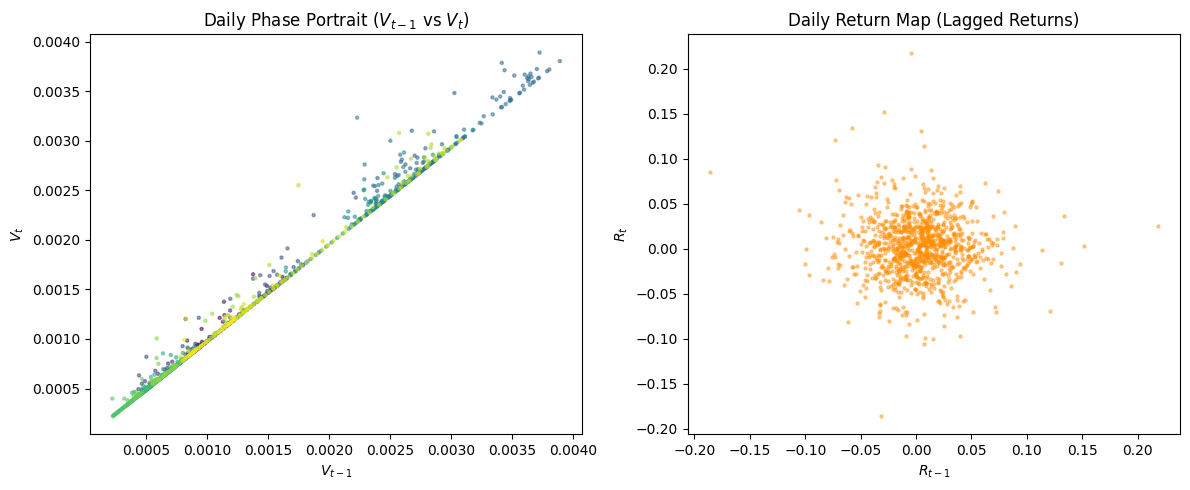

--- DAILY CHAOS RESULTS ---
Hurst Exponent: 0.9026
Lyapunov Exp:   0.0048


/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 258
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 54
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt
import nolds # For Hurst and Lyapunov

def daily_chaos_analysis(df):
    # 1. Plot Daily Phase Portrait
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Compare Today's Vol vs Yesterday's Vol
    plt.scatter(df['V_t'].shift(1), df['V_t'], alpha=0.5, s=5, c=df.index, cmap='viridis')
    plt.title("Daily Phase Portrait ($V_{t-1}$ vs $V_t$)")
    plt.xlabel("$V_{t-1}$")
    plt.ylabel("$V_t$")
    
    # 2. Plot Attractor in Return Space
    plt.subplot(1, 2, 2)
    # Using 'Delay Embedding' to see if a geometric shape emerges
    plt.scatter(df['Log_Return'].shift(1), df['Log_Return'], alpha=0.4, s=5, color='darkorange')
    plt.title("Daily Return Map (Lagged Returns)")
    plt.xlabel("$R_{t-1}$")
    plt.ylabel("$R_t$")
    
    plt.tight_layout()
    plt.show()

    # 3. Calculate Quantitative Chaos
    h_exp = nolds.hurst_rs(df['V_t'].values)
    lyap_exp = nolds.lyap_r(df['V_t'].values)
    
    print(f"--- DAILY CHAOS RESULTS ---")
    print(f"Hurst Exponent: {h_exp:.4f}")
    print(f"Lyapunov Exp:   {lyap_exp:.4f}")

daily_chaos_analysis(processed_df)

In [14]:
import nolds
import numpy as np

def calculate_daily_chaos(series):
    # 1. Hurst Exponent (R/S Analysis)
    # Measures the 'trendiness' or memory of the series
    h = nolds.hurst_rs(series)
    
    # 2. Lyapunov Exponent (Rosenstein's Algorithm)
    # Measures the exponential rate of divergence of close trajectories
    # Note: Requires a sufficient number of data points (ideally > 1000)
    lyap = nolds.lyap_r(series)
    
    # 3. Correlation Dimension
    # Measures the complexity/dimensionality of the attractor
    dim = nolds.corr_dim(series, emb_dim=2)
    
    print(f"--- DAILY CHAOS ANALYSIS ---")
    print(f"Hurst Exponent (H):      {h:.4f}")
    print(f"Lyapunov Exponent (λ): {lyap:.4f}")
    print(f"Correlation Dimension:  {dim:.4f}")

calculate_daily_chaos(processed_df['V_t'].values)

--- DAILY CHAOS ANALYSIS ---
Hurst Exponent (H):      0.9026
Lyapunov Exponent (λ): 0.0048
Correlation Dimension:  1.0099


/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:263: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 258
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:292: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 54
  warnings.warn(msg.format(lag), RuntimeWarning)
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/home/tek/projects/MSc-Mathematics/.venv/lib/python3.12/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the packa

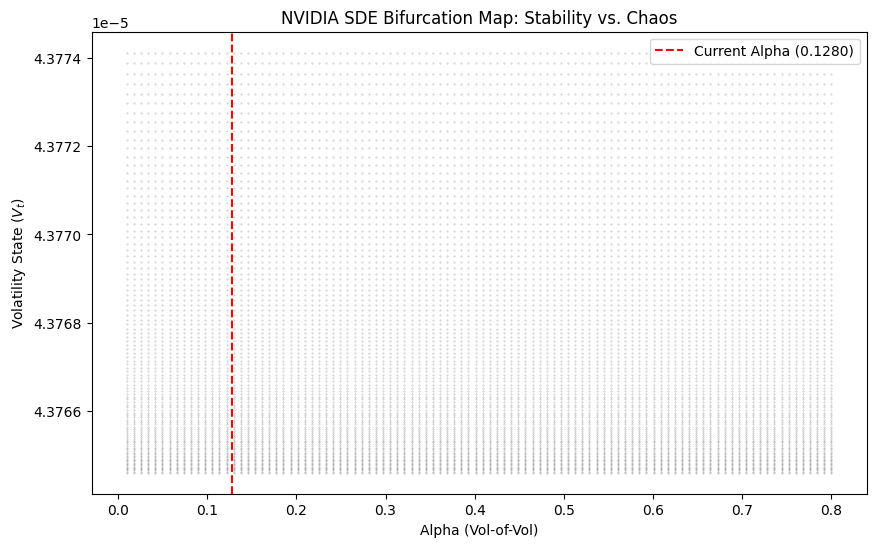

In [16]:
def generate_bifurcation_data(df, cp):
    alphas = np.linspace(0.01, 0.8, 100) # Range of Alpha to test
    bifurcation_points = []
    
    # Use your existing Kappa and Theta
    k, th, h = cp['kappa'], cp['theta'], cp['h']
    dt = 1 # Daily
    
    for a in alphas:
        v = th / (2 * k) # Start at equilibrium
        # Simulation to find steady-state/attractor
        for t in range(500): # Warm-up
            innov = a * (np.random.normal(0, np.sqrt(th))**2 - h * dt)
            v = v + k * (th - v) * dt + max(innov, 0)
        
        # Collect points for the attractor
        for t in range(100):
            innov = a * (np.random.normal(0, np.sqrt(th))**2 - h * dt)
            v = v + k * (th - v) * dt + max(innov, 0)
            bifurcation_points.append([a, v])
            
    return np.array(bifurcation_points)

# Plotting the result
data = generate_bifurcation_data(processed_df, cogarch_params)
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], s=0.1, color='black', alpha=0.3)
plt.axvline(x=0.1280, color='red', linestyle='--', label='Current Alpha (0.1280)')
plt.title("NVIDIA SDE Bifurcation Map: Stability vs. Chaos")
plt.xlabel("Alpha (Vol-of-Vol)")
plt.ylabel("Volatility State ($V_t$)")
plt.legend()
plt.show()